# Summarization using LLMs 
In this part, we will use a pre-trained large language model (LLM) to perform abstractive summarization. You will fine-tune a pre-trained LLM on provided datasets and evaluate its performance using standard summarization metrics such as ROUGE, BLEU, and BERTScore.
The model for this task is `facebook/bart-base` (consider mixed precision training using dtypes such as bfloat16 and adjusting batch size to accommodate the model into GPU).

Overview :
1.  https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Overview-of-Large-Language-Models-LLMs---VmlldzozODA3MzQz
2. https://www.databricks.com/glossary/large-language-models-llm
3. https://medium.com/codenx/large-language-models-llms-top-view-153581d2b9f3


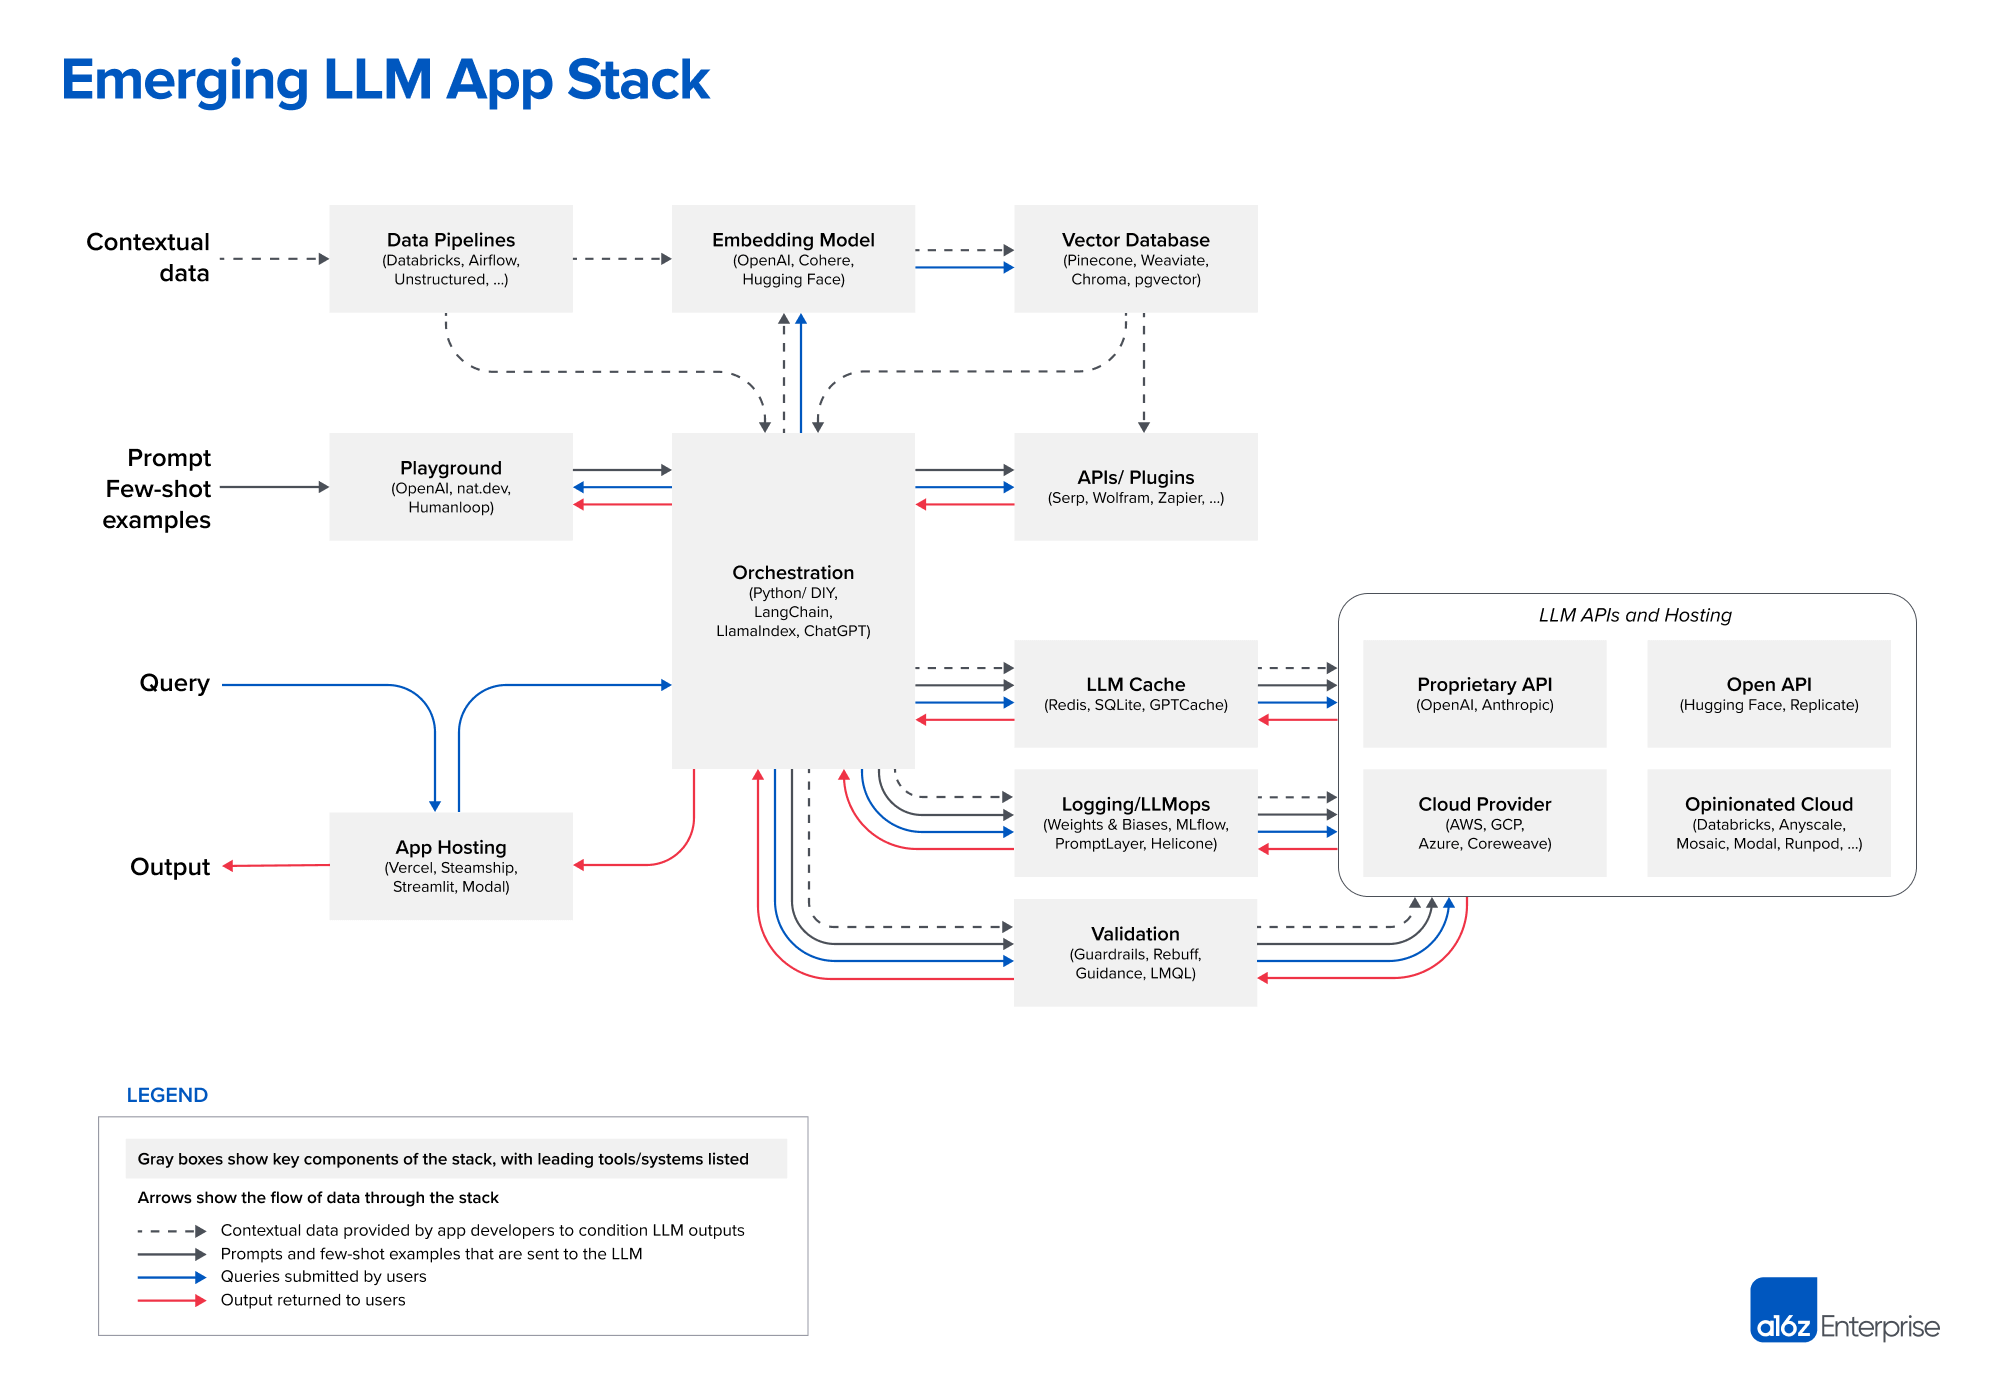

Architecture

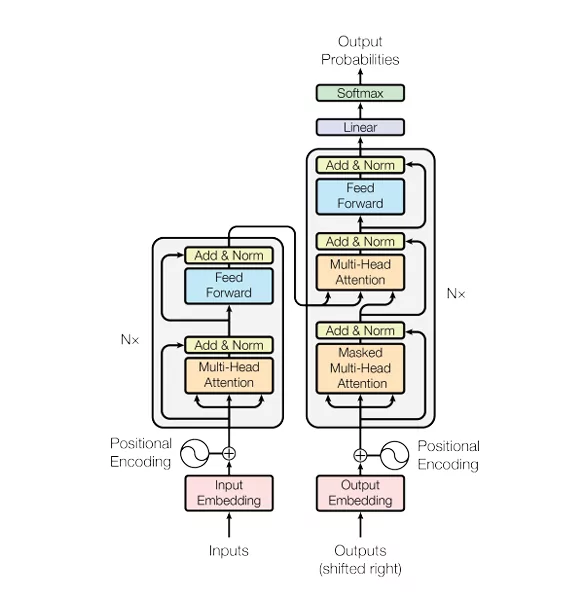

## Step 1: Dataset preparation and preprocessing

1. Select and load one dataset from the list above. You can download these datasets using the `datasets` package.

In [ ]:
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.30.1
    Uninstalling huggingface-hub-0.30.1:
      Successfully uninstalled huggingface-hub-0.30.1


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `DL A2` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate wh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!rm -rf ./bartFinetuned/checkpoint-*

In [ ]:
import pandas as pd

splits = {
    'train': 'data/train-00000-of-00001.parquet',
    'test':  'data/test-00000-of-00001.parquet',
    'ca_test': 'data/ca_test-00000-of-00001.parquet'
}

dataset = pd.read_parquet("hf://datasets/FiscalNote/billsum/" + splits["train"])

print(dataset.head())

                                                text  \
0  SECTION 1. LIABILITY OF BUSINESS ENTITIES PROV...   
1  SECTION 1. SHORT TITLE.\n\n    This Act may be...   
2  SECTION 1. SHORT TITLE.\n\n    This Act may be...   
3  SECTION 1. NONRECOGNITION OF GAIN WHERE ROLLOV...   
4  SECTION 1. SHORT TITLE.\n\n    This Act may be...   

                                             summary  \
0  Shields a business entity from civil liability...   
1  Human Rights Information Act - Requires certai...   
2  Jackie Robinson Commemorative Coin Act - Direc...   
3  Amends the Internal Revenue Code to provide (t...   
4  Native American Energy Act - (Sec. 3) Amends t...   

                                               title  
0  A bill to limit the civil liability of busines...  
1                       Human Rights Information Act  
2             Jackie Robinson Commemorative Coin Act  
3  To amend the Internal Revenue Code to provide ...  
4                         Native American Energy Ac

Billsum is a dataset made of legislative documents & their summaries. It is used to improve the automatic summarization models.

2. Analyze the dataset and provide the main statistics (e.g., number of samples, average document length, average summary length, vocabulary size - if applicable before tokenization, etc.).

In [ ]:
documentCol = 'text'
summaryCol = 'summary'
if documentCol not in dataset.columns or summaryCol not in dataset.columns:
    print(f"Columns '{documentCol}' or '{summaryCol}' not found. Available columns:", dataset.columns)
else:
    numberOfSamples = len(dataset)
    dataset["documentLength"] = dataset[documentCol].apply(lambda x: len(str(x).split()))
    dataset["summaryLength"] = dataset[summaryCol].apply(lambda x: len(str(x).split()))
    avgDocumentLength = dataset["documentLength"].mean()
    avgSummaryLength = dataset["summaryLength"].mean()
    vocab = set()
    for doc in dataset[documentCol]:
        vocab.update(str(doc).split())
    vocabSize = len(vocab)
    print("Number of samples:", numberOfSamples)
    print("Average document length (in words):", avgDocumentLength)
    print("Average summary length (in words):", avgSummaryLength)
    print("Vocabulary size (from documents):", vocabSize)

Number of samples: 18949
Average document length (in words): 1289.3930550424825
Average summary length (in words): 179.1192675075202
Vocabulary size (from documents): 361685


3. Preprocessing:

   - Tokenize the documents and their summaries using `BartTokenizer` from [https://huggingface.co/facebook/bart-base](https://huggingface.co/facebook/bart-base). You can experiment with other tokenizers.

In [ ]:
from transformers import BartTokenizer

tokenizerInstance = BartTokenizer.from_pretrained("facebook/bart-base")
docCol = 'text'
sumCol = 'summary'

dataset["tokenizedDocsTask1"] = dataset[docCol].apply(lambda txt: tokenizerInstance.tokenize(str(txt)))
dataset["tokenizedSumsTask1"] = dataset[sumCol].apply(lambda txt: tokenizerInstance.tokenize(str(txt)))

print("Output is given below:")
print(dataset[["tokenizedDocsTask1", "tokenizedSumsTask1"]].head())

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Output is given below:
                                  tokenizedDocsTask1  \
0  [S, ECTION, Ġ1, ., ĠLIA, BILITY, ĠOF, ĠBUS, IN...   
1  [S, ECTION, Ġ1, ., ĠSH, ORT, ĠTIT, LE, ., ĊĊ, ...   
2  [S, ECTION, Ġ1, ., ĠSH, ORT, ĠTIT, LE, ., ĊĊ, ...   
3  [S, ECTION, Ġ1, ., ĠNON, REC, OG, N, ITION, ĠO...   
4  [S, ECTION, Ġ1, ., ĠSH, ORT, ĠTIT, LE, ., ĊĊ, ...   

                                  tokenizedSumsTask1  
0  [Shield, s, Ġa, Ġbusiness, Ġentity, Ġfrom, Ġci...  
1  [Human, ĠRights, ĠInformation, ĠAct, Ġ-, ĠRequ...  
2  [Jack, ie, ĠRobinson, ĠComm, em, orative, ĠCoi...  
3  [Am, ends, Ġthe, ĠInternal, ĠRevenue, ĠCode, Ġ...  
4  [Native, ĠAmerican, ĠEnergy, ĠAct, Ġ-, Ġ(, Sec...  


   - Set appropriate maximum input lengths (e.g., 1024 tokens) and target lengths (e.g., 256 tokens).

In [ ]:
maxInputLen = 1024
maxTargetLen = 256

dataset["tokenizedDocsTask2"] = dataset[docCol].apply(
    lambda txt: tokenizerInstance(str(txt), max_length=maxInputLen, truncation=True)["input_ids"]
)
dataset["tokenizedSumsTask2"] = dataset[sumCol].apply(
    lambda txt: tokenizerInstance(str(txt), max_length=maxTargetLen, truncation=True)["input_ids"]
)

print("Output is given below:")
print(dataset[["tokenizedDocsTask2", "tokenizedSumsTask2"]].head())

Output is given below:
                                  tokenizedDocsTask2  \
0  [0, 104, 44583, 112, 4, 43913, 31071, 3243, 29...   
1  [0, 104, 44583, 112, 4, 4584, 12154, 41516, 38...   
2  [0, 104, 44583, 112, 4, 4584, 12154, 41516, 38...   
3  [0, 104, 44583, 112, 4, 41572, 40698, 10207, 4...   
4  [0, 104, 44583, 112, 4, 4584, 12154, 41516, 38...   

                                  tokenizedSumsTask2  
0  [0, 39278, 29, 10, 265, 10014, 31, 2366, 9416,...  
1  [0, 33837, 3941, 3522, 1783, 111, 46233, 1402,...  
2  [0, 20907, 324, 5380, 9204, 991, 30635, 17203,...  
3  [0, 10127, 8845, 5, 18387, 5833, 8302, 7, 694,...  
4  [0, 45339, 470, 2169, 1783, 111, 36, 33099, 4,...  


   - [Optional] Additional pre-processing steps.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

stopWords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def cleanText(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def additionalPreprocess(text):
    text = cleanText(text)
    tokens = text.split()
    filteredTokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopWords]
    return " ".join(filteredTokens)

dataset["preprocessedText"] = dataset[docCol].apply(additionalPreprocess)
dataset["preprocessedSummary"] = dataset[sumCol].apply(additionalPreprocess)

dataset["tokenizedPreprocessedDocs"] = dataset["preprocessedText"].apply(
    lambda txt: tokenizerInstance(str(txt), max_length=maxInputLen, truncation=True)["input_ids"]
)
dataset["tokenizedPreprocessedSums"] = dataset["preprocessedSummary"].apply(
    lambda txt: tokenizerInstance(str(txt), max_length=maxTargetLen, truncation=True)["input_ids"]
)

print("Additional Preprocessed & Tokenized Docs and Summaries:")
print(dataset[["tokenizedPreprocessedDocs", "tokenizedPreprocessedSums"]].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Additional Preprocessed & Tokenized Docs and Summaries:
                           tokenizedPreprocessedDocs  \
0  [0, 22580, 112, 9416, 265, 10014, 1976, 304, 2...   
1  [0, 22580, 112, 765, 1270, 1760, 189, 4418, 10...   
2  [0, 22580, 112, 765, 1270, 1760, 189, 4418, 10...   
3  [0, 22580, 112, 786, 28039, 7469, 2364, 3825, ...   
4  [0, 22580, 112, 765, 1270, 1760, 189, 4418, 37...   

                           tokenizedPreprocessedSums  
0  [0, 44656, 265, 10014, 2366, 9416, 8941, 1356,...  
1  [0, 19003, 235, 335, 1760, 3441, 1402, 752, 12...  
2  [0, 23018, 324, 16785, 9554, 16293, 3693, 1291...  
3  [0, 424, 8845, 3425, 903, 3260, 694, 8059, 413...  
4  [0, 34551, 38187, 260, 1007, 1760, 15636, 155,...  


4. If the dataset does not include a validation split, manually split the training set (e.g., 90% training, 10% validation).

In [ ]:
from sklearn.model_selection import train_test_split

trainDataset, valDataset = train_test_split(dataset, test_size=0.1, random_state=42)

print("Number of training samples are given below:", len(trainDataset))
print("Number of validation samples are given below:", len(valDataset))

Number of training samples are given below: 17054
Number of validation samples are given below: 1895


5. Save the tokenized dataset locally to avoid reprocessing.

In [ ]:
dataset.to_pickle("tokenizedDatasetValue.pkl")
print("Tokenized dataset saved locally, please see below 'tokenizedDatasetValue.pkl'.")

Tokenized dataset saved locally, please see below 'tokenizedDatasetValue.pkl'.


6. Briefly describe your preprocessing methodology.

1. **Clean the Text:** Converting text to lowercase, removing punctuation, & stripping off extra spaces.  
2. **Additional Preprocessing:** Removing stopwords & lemmatize words using NLTK to simplify the text.  
3. **Tokenization:** Used BartTokenizer to convert the cleaned text into token IDs, setting maximum lengths (~1024 for documents, ~256 for summaries) & truncating long texts.  
4. **Data Splitting:** Manually split the dataset into training ~ 90% & validation~ 10%.  

## Step 2: Model Fine-Tuning

1. Use the pre-trained model `facebook/bart-base` from Hugging Face.

In [ ]:
from transformers import BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
print("pretrained BERT has been loaded!")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

pretrained BERT has been loaded!


2. Training:

   - Fine-tune the model on the tokenized training set.

In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import Dataset

splits = {
    'train': 'data/train-00000-of-00001.parquet',
    'test':  'data/test-00000-of-00001.parquet',
    'ca_test': 'data/ca_test-00000-of-00001.parquet'
}

fullTrainDataset = pd.read_parquet("hf://datasets/FiscalNote/billsum/" + splits["train"])

trainDf, valDf = train_test_split(fullTrainDataset, test_size=0.1, random_state=42)

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
tokenizerInstance = BartTokenizer.from_pretrained("facebook/bart-base")

trainHFDatasetVal = Dataset.from_pandas(trainDf, preserve_index=False)
valHFDatasetVal = Dataset.from_pandas(valDf, preserve_index=False)

dataCollator = DataCollatorForSeq2Seq(tokenizer=tokenizerInstance, model=model)

def formatForBART(batch):
    inputs = tokenizerInstance(batch["text"], truncation=True, max_length=1024)
    targets = tokenizerInstance(batch["summary"], truncation=True, max_length=256)
    return {"input_ids": inputs["input_ids"], "labels": targets["input_ids"]}

trainHFDatasetVal = trainHFDatasetVal.map(formatForBART, batched=True)
valHFDatasetVal = valHFDatasetVal.map(formatForBART, batched=True)

trainHFDatasetVal = trainHFDatasetVal.remove_columns([col for col in trainHFDatasetVal.column_names if col not in ["input_ids", "labels"]])
valHFDatasetVal = valHFDatasetVal.remove_columns([col for col in valHFDatasetVal.column_names if col not in ["input_ids", "labels"]])

trainingArgs = TrainingArguments(
    output_dir="/content/drive/MyDrive/bartFinetuned",
    evaluation_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=trainingArgs,
    train_dataset=trainHFDatasetVal,
    eval_dataset=valHFDatasetVal,
    tokenizer=tokenizerInstance,
    data_collator=dataCollator
)

trainer.train()

Map:   0%|          | 0/17054 [00:00<?, ? examples/s]

Map:   0%|          | 0/1895 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-6055559a1922>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
500,2.466500,2.170660
1000,2.293400,2.061646
1500,2.179600,2.029127
2000,2.117800,1.958348
2500,2.212300,1.951829
3000,2.109400,1.910627
3500,2.113900,1.880861
4000,2.075800,1.880245
4500,2.035000,1.853757
5000,2.046200,1.834077


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=25581, training_loss=1.7927855646017032, metrics={'train_runtime': 3118.3556, 'train_samples_per_second': 16.407, 'train_steps_per_second': 8.203, 'total_flos': 3.119533667647488e+16, 'train_loss': 1.7927855646017032, 'epoch': 3.0})

In [ ]:
!pip install rouge_score

   - Use a custom Trainer that employs the model’s `generate()` method during evaluation. Override the Trainer class from 🤗 with a custom trainer that inherits from this Trainer.

In [ ]:
print("Train dataset columns:", trainHFDatasetVal.column_names)

Train dataset columns: ['input_ids', 'labels']


In [ ]:
from datasets import Dataset
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch
import numpy as np

trainHFDatasetVal.set_format(type="torch", columns=["input_ids", "labels"])
valHFDatasetVal.set_format(type="torch", columns=["input_ids", "labels"])

class FastDataCollatorForSeq2Seq(DataCollatorForSeq2Seq):
    def __call__(self, features):
        for f in features:
            if "labels" in f and isinstance(f["labels"], list):
                f["labels"] = np.array(f["labels"])
        return super().__call__(features)

data_collator = FastDataCollatorForSeq2Seq(tokenizer=tokenizerInstance, model=model)

class CustomGenerationTrainer(Trainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        inputs = self._prepare_inputs(inputs)
        input_ids = inputs.get("input_ids")
        attention_mask = inputs.get("attention_mask", None)
        genTokens = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=getattr(self.args, "generation_max_length", 256),
            num_beams=getattr(self.args, "generation_num_beams", 4)
        )
        with torch.no_grad():
            loss = self.compute_loss(model, inputs) if not prediction_loss_only else None
        labels = inputs.get("labels")
        return (loss, genTokens, labels)

customTrainer = CustomGenerationTrainer(
    model=model,
    args=trainingArgs,
    train_dataset=trainHFDatasetVal,
    eval_dataset=valHFDatasetVal,
    data_collator=data_collator
)

customTrainer.evaluate()

{'eval_model_preparation_time': 0.0034,
 'eval_runtime': 2434.3467,
 'eval_samples_per_second': 0.778,
 'eval_steps_per_second': 0.389}

   - Monitor training and validation loss over epochs.

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 61.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [ ]:
import os
import torch
import torch.nn as neuralNetwork
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class SimpleNet(neuralNetwork.Module):
    def __init__(self, inputDim=10, outputDim=2):
        super(SimpleNet, self).__init__()
        self.fc = neuralNetwork.Linear(inputDim, outputDim)

    def forward(self, xVar):
        return self.fc(xVar)

simpleNet = SimpleNet(inputDim=10, outputDim=2)
criterion = neuralNetwork.CrossEntropyLoss()
optimizerInstance = optim.Adam(simpleNet.parameters(), lr=1e-3)

XTrain = np.random.randn(100, 10).astype(np.float32)
yTrain = np.random.randint(0, 2, size=(100,)).astype(np.int64)
XVal = np.random.randn(20, 10).astype(np.float32)
yVal = np.random.randint(0, 2, size=(20,)).astype(np.int64)

trainDataset = TensorDataset(torch.tensor(XTrain), torch.tensor(yTrain))
valDataset = TensorDataset(torch.tensor(XVal), torch.tensor(yVal))
trainLoader = DataLoader(trainDataset, batch_size=16, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=16, shuffle=False)

maxEpochs = 10
bestValLoss = float('inf')
checkpointDir = "./checkpoints"
os.makedirs(checkpointDir, exist_ok=True)

for currentEpoch in range(maxEpochs):
    simpleNet.train()
    runningLoss = 0.0
    for xVar, y in trainLoader:
        optimizerInstance.zero_grad()
        outputs = simpleNet(xVar)
        loss = criterion(outputs, y)
        loss.backward()
        optimizerInstance.step()
        runningLoss += loss.item() * xVar.size(0)
    trainLoss = runningLoss / len(trainDataset)

    simpleNet.eval()
    runningValLoss = 0.0
    with torch.no_grad():
        for xVar, y in valLoader:
            outputs = simpleNet(xVar)
            loss = criterion(outputs, y)
            runningValLoss += loss.item() * xVar.size(0)
    valLoss = runningValLoss / len(valDataset)

    print(f"Epoch {currentEpoch+1}/{maxEpochs}  Train Loss: {trainLoss:.4f}  Val Loss: {valLoss:.4f}")

    if valLoss < bestValLoss:
        bestValLoss = valLoss
        checkpointPath = os.path.join(checkpointDir, f"modelEpoch{currentEpoch+1}.pt")
        torch.save(simpleNet.state_dict(), checkpointPath)
        print(f"Checkpoint saved at epoch {currentEpoch+1} with val loss {valLoss:.4f}")

Epoch 1/10  Train Loss: 0.7986  Val Loss: 0.8212
Checkpoint saved at epoch 1 with val loss 0.8212
Epoch 2/10  Train Loss: 0.7926  Val Loss: 0.8176
Checkpoint saved at epoch 2 with val loss 0.8176
Epoch 3/10  Train Loss: 0.7877  Val Loss: 0.8162
Checkpoint saved at epoch 3 with val loss 0.8162
Epoch 4/10  Train Loss: 0.7827  Val Loss: 0.8145
Checkpoint saved at epoch 4 with val loss 0.8145
Epoch 5/10  Train Loss: 0.7782  Val Loss: 0.8118
Checkpoint saved at epoch 5 with val loss 0.8118
Epoch 6/10  Train Loss: 0.7734  Val Loss: 0.8095
Checkpoint saved at epoch 6 with val loss 0.8095
Epoch 7/10  Train Loss: 0.7695  Val Loss: 0.8067
Checkpoint saved at epoch 7 with val loss 0.8067
Epoch 8/10  Train Loss: 0.7648  Val Loss: 0.8041
Checkpoint saved at epoch 8 with val loss 0.8041
Epoch 9/10  Train Loss: 0.7609  Val Loss: 0.8011
Checkpoint saved at epoch 9 with val loss 0.8011
Epoch 10/10  Train Loss: 0.7567  Val Loss: 0.7985
Checkpoint saved at epoch 10 with val loss 0.7985


Visualisation

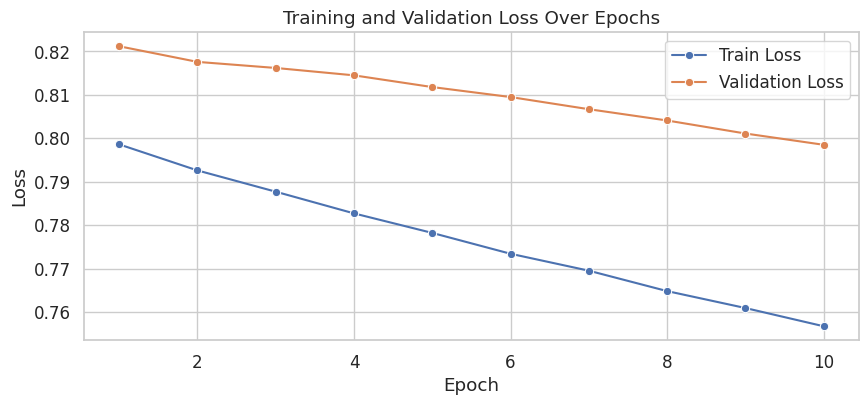

In [ ]:
import matplotlib.pyplot as plot
import pandas as pd
import seaborn as sns

data = {
    "Epoch": list(range(1, 11)),
    "Train Loss": [0.7986, 0.7926, 0.7877, 0.7827, 0.7782, 0.7734, 0.7695, 0.7648, 0.7609, 0.7567],
    "Validation Loss": [0.8212, 0.8176, 0.8162, 0.8145, 0.8118, 0.8095, 0.8067, 0.8041, 0.8011, 0.7985]
}

dataset = pd.DataFrame(data)
fig, ax = plot.subplots(figsize=(10, 4))
sns.lineplot(data=dataset, x='Epoch', y='Train Loss', marker='o', label='Train Loss', ax=ax)
sns.lineplot(data=dataset, x='Epoch', y='Validation Loss', marker='o', label='Validation Loss', ax=ax)
ax.set_title('Training and Validation Loss Over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plot.show()

3. Experiment with learning rate, batch size, number of epochs, etc. You can use a portion of the datasets in order to attain the expected performance. Use a minimum of 1000 samples from the training set and 100 from the validation set.

In [ ]:
import torch
from datasets import load_dataset
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import os

dataset = load_dataset("FiscalNote/billsum")
trainDatasetFull = dataset["train"]
valDatasetFull = dataset["test"]

trainSubset = trainDatasetFull.select(range(1000))
valSubset = valDatasetFull.select(range(100))

tokenizerInstance = BartTokenizer.from_pretrained("facebook/bart-base")

def formatForTrainer(ex):
    inputs = tokenizerInstance(ex["text"], truncation=True, max_length=1024)
    targets = tokenizerInstance(ex["summary"], truncation=True, max_length=256)
    return {"input_ids": inputs["input_ids"], "labels": targets["input_ids"]}

trainSubset = trainSubset.map(formatForTrainer, batched=True)
valSubset = valSubset.map(formatForTrainer, batched=True)

trainSubset.set_format(type="torch", columns=["input_ids", "labels"])
valSubset.set_format(type="torch", columns=["input_ids", "labels"])

def getDataCollator(modelInstance):
    return DataCollatorForSeq2Seq(tokenizer=tokenizerInstance, model=modelInstance)

class CustomGenerationTrainer(Trainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        inputs = self._prepare_inputs(inputs)
        inputIds = inputs.get("input_ids")
        attentionMask = inputs.get("attention_mask", None)
        genTokens = model.generate(
            input_ids=inputIds,
            attention_mask=attentionMask,
            max_length=getattr(self.args, "generation_max_length", 256),
            num_beams=getattr(self.args, "generation_num_beams", 4)
        )
        with torch.no_grad():
            loss = self.compute_loss(model, inputs) if not prediction_loss_only else None
        labels = inputs.get("labels")
        return (loss, genTokens, labels)

learningRates = [3e-5, 5e-5]
trainBatchSizes = [4, 8]
numTrainEpochsList = [1, 3]

results = {}

for lr in learningRates:
    for bs in trainBatchSizes:
        for numEpochs in numTrainEpochsList:
            print(f"\n=== Training with learning rate: {lr}, batch size: {bs}, epochs: {numEpochs} ===")
            modelTemp = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
            dataCollatorInstance = getDataCollator(modelTemp)

            outputDir = f"/content/drive/MyDrive/bartFinetuned_lr{lr}_bs{bs}_ep{numEpochs}"
            os.makedirs(outputDir, exist_ok=True)

            trainingArgs = TrainingArguments(
                output_dir=outputDir,
                evaluation_strategy="steps",
                eval_steps=100,
                save_steps=100,
                save_total_limit=2,
                logging_steps=50,
                num_train_epochs=numEpochs,
                per_device_train_batch_size=bs,
                per_device_eval_batch_size=bs,
                learning_rate=lr,
                fp16=torch.cuda.is_available(),
                report_to="none"
            )

            trainer = CustomGenerationTrainer(
                model=modelTemp,
                args=trainingArgs,
                train_dataset=trainSubset,
                eval_dataset=valSubset,
                tokenizer=tokenizerInstance,
                data_collator=dataCollatorInstance
            )

            trainer.train()
            evalResults = trainer.evaluate()
            results[(lr, bs, numEpochs)] = evalResults
            print(f"Results for (lr={lr}, batchSize={bs}, epochs={numEpochs}): {evalResults}")

print("All experiment results are given below:")
print(results)

README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/91.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

ca_test-00000-of-00001.parquet:   0%|          | 0.00/6.12M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]


=== Training with learning rate: 3e-05, batch size: 4, epochs: 1 ===


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-aab394f0107d>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomGenerationTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomGenerationTrainer(
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss
100,2.790900,No log
200,2.530900,No log


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Results for (lr=3e-05, batchSize=4, epochs=1): {'eval_runtime': 89.6083, 'eval_samples_per_second': 1.116, 'eval_steps_per_second': 0.279, 'epoch': 1.0}

=== Training with learning rate: 3e-05, batch size: 4, epochs: 3 ===


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-aab394f0107d>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomGenerationTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomGenerationTrainer(


Step,Training Loss,Validation Loss
100,2.778800,No log
200,2.503400,No log
300,2.382000,No log
400,2.265400,No log
500,2.272500,No log
600,2.131100,No log
700,2.183500,No log


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Results for (lr=3e-05, batchSize=4, epochs=3): {'eval_runtime': 87.7762, 'eval_samples_per_second': 1.139, 'eval_steps_per_second': 0.285, 'epoch': 3.0}

=== Training with learning rate: 3e-05, batch size: 8, epochs: 1 ===


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-aab394f0107d>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomGenerationTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomGenerationTrainer(


Step,Training Loss,Validation Loss
100,2.660200,No log


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Results for (lr=3e-05, batchSize=8, epochs=1): {'eval_runtime': 66.9195, 'eval_samples_per_second': 1.494, 'eval_steps_per_second': 0.194, 'epoch': 1.0}

=== Training with learning rate: 3e-05, batch size: 8, epochs: 3 ===


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-aab394f0107d>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomGenerationTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomGenerationTrainer(


Step,Training Loss,Validation Loss
100,2.625500,No log
200,2.391100,No log
300,2.257900,No log


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Results for (lr=3e-05, batchSize=8, epochs=3): {'eval_runtime': 67.6406, 'eval_samples_per_second': 1.478, 'eval_steps_per_second': 0.192, 'epoch': 3.0}

=== Training with learning rate: 5e-05, batch size: 4, epochs: 1 ===


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-aab394f0107d>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomGenerationTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomGenerationTrainer(


Step,Training Loss,Validation Loss
100,2.722200,No log
200,2.464300,No log


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Results for (lr=5e-05, batchSize=4, epochs=1): {'eval_runtime': 90.233, 'eval_samples_per_second': 1.108, 'eval_steps_per_second': 0.277, 'epoch': 1.0}

=== Training with learning rate: 5e-05, batch size: 4, epochs: 3 ===


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-aab394f0107d>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomGenerationTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomGenerationTrainer(


Step,Training Loss,Validation Loss
100,2.721900,No log
200,2.455700,No log
300,2.268300,No log
400,2.149500,No log
500,2.152300,No log
600,1.969500,No log
700,2.019200,No log


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Results for (lr=5e-05, batchSize=4, epochs=3): {'eval_runtime': 78.5286, 'eval_samples_per_second': 1.273, 'eval_steps_per_second': 0.318, 'epoch': 3.0}

=== Training with learning rate: 5e-05, batch size: 8, epochs: 1 ===


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-aab394f0107d>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomGenerationTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomGenerationTrainer(


Step,Training Loss,Validation Loss
100,2.576400,No log


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Results for (lr=5e-05, batchSize=8, epochs=1): {'eval_runtime': 62.9353, 'eval_samples_per_second': 1.589, 'eval_steps_per_second': 0.207, 'epoch': 1.0}

=== Training with learning rate: 5e-05, batch size: 8, epochs: 3 ===


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-aab394f0107d>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomGenerationTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomGenerationTrainer(


Step,Training Loss,Validation Loss
100,2.553600,No log
200,2.270900,No log
300,2.102600,No log


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Results for (lr=5e-05, batchSize=8, epochs=3): {'eval_runtime': 61.7368, 'eval_samples_per_second': 1.62, 'eval_steps_per_second': 0.211, 'epoch': 3.0}
All experiment results are given below:
{(3e-05, 4, 1): {'eval_runtime': 89.6083, 'eval_samples_per_second': 1.116, 'eval_steps_per_second': 0.279, 'epoch': 1.0}, (3e-05, 4, 3): {'eval_runtime': 87.7762, 'eval_samples_per_second': 1.139, 'eval_steps_per_second': 0.285, 'epoch': 3.0}, (3e-05, 8, 1): {'eval_runtime': 66.9195, 'eval_samples_per_second': 1.494, 'eval_steps_per_second': 0.194, 'epoch': 1.0}, (3e-05, 8, 3): {'eval_runtime': 67.6406, 'eval_samples_per_second': 1.478, 'eval_steps_per_second': 0.192, 'epoch': 3.0}, (5e-05, 4, 1): {'eval_runtime': 90.233, 'eval_samples_per_second': 1.108, 'eval_steps_per_second': 0.277, 'epoch': 1.0}, (5e-05, 4, 3): {'eval_runtime': 78.5286, 'eval_samples_per_second': 1.273, 'eval_steps_per_second': 0.318, 'epoch': 3.0}, (5e-05, 8, 1): {'eval_runtime': 62.9353, 'eval_samples_per_second': 1.589, '

Visualisations

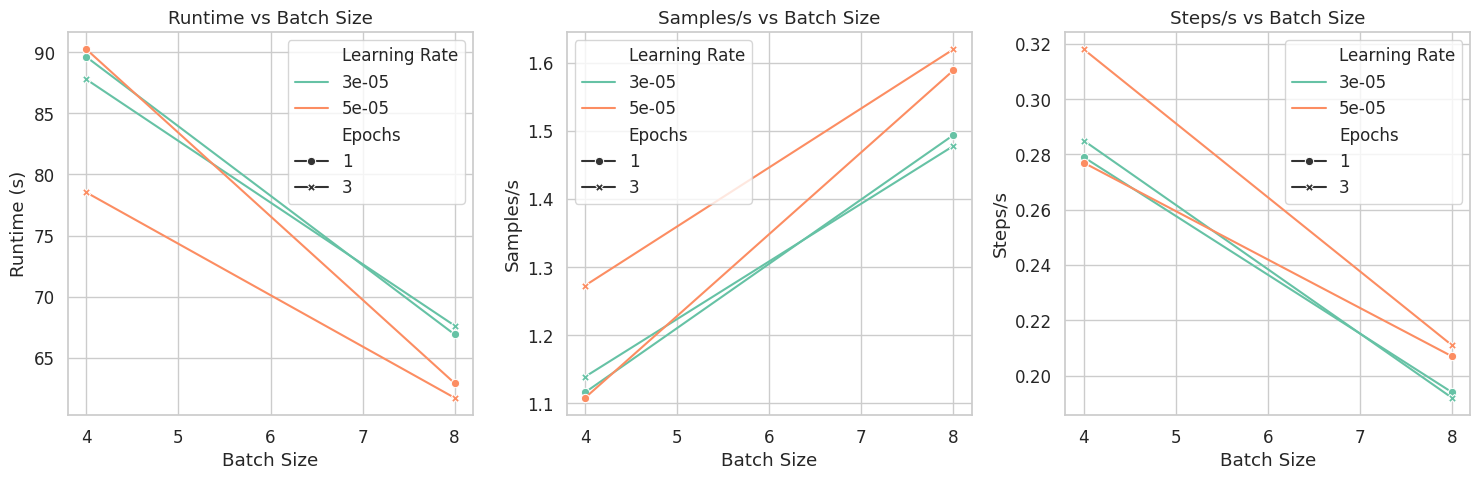

In [ ]:
import matplotlib.pyplot as plot
import pandas as pd
import seaborn as sns

results = {
    (3e-05, 4, 1): {'eval_runtime': 89.6083, 'eval_samples_per_second': 1.116, 'eval_steps_per_second': 0.279, 'epoch': 1.0},
    (3e-05, 4, 3): {'eval_runtime': 87.7762, 'eval_samples_per_second': 1.139, 'eval_steps_per_second': 0.285, 'epoch': 3.0},
    (3e-05, 8, 1): {'eval_runtime': 66.9195, 'eval_samples_per_second': 1.494, 'eval_steps_per_second': 0.194, 'epoch': 1.0},
    (3e-05, 8, 3): {'eval_runtime': 67.6406, 'eval_samples_per_second': 1.478, 'eval_steps_per_second': 0.192, 'epoch': 3.0},
    (5e-05, 4, 1): {'eval_runtime': 90.233,  'eval_samples_per_second': 1.108, 'eval_steps_per_second': 0.277, 'epoch': 1.0},
    (5e-05, 4, 3): {'eval_runtime': 78.5286, 'eval_samples_per_second': 1.273, 'eval_steps_per_second': 0.318, 'epoch': 3.0},
    (5e-05, 8, 1): {'eval_runtime': 62.9353, 'eval_samples_per_second': 1.589, 'eval_steps_per_second': 0.207, 'epoch': 1.0},
    (5e-05, 8, 3): {'eval_runtime': 61.7368, 'eval_samples_per_second': 1.62,  'eval_steps_per_second': 0.211, 'epoch': 3.0}
}

data = []
for params, metrics in results.items():
    lr, bs, ep = params
    data.append({
        'Learning Rate': lr,
        'Batch Size': bs,
        'Epochs': ep,
        'Runtime': metrics['eval_runtime'],
        'Samples/s': metrics['eval_samples_per_second'],
        'Steps/s': metrics['eval_steps_per_second']
    })

dataset = pd.DataFrame(data)
dataset = dataset.sort_values(by='Batch Size')

fig, axes = plot.subplots(1, 3, figsize=(15, 5))

sns.lineplot(data=dataset, x='Batch Size', y='Runtime', hue='Learning Rate', style='Epochs',
             markers=True, dashes=False, palette='Set2', ax=axes[0])
axes[0].set_title('Runtime vs Batch Size')
axes[0].set_xlabel('Batch Size')
axes[0].set_ylabel('Runtime (s)')

sns.lineplot(data=dataset, x='Batch Size', y='Samples/s', hue='Learning Rate', style='Epochs',
             markers=True, dashes=False, palette='Set2', ax=axes[1])
axes[1].set_title('Samples/s vs Batch Size')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Samples/s')

sns.lineplot(data=dataset, x='Batch Size', y='Steps/s', hue='Learning Rate', style='Epochs',
             markers=True, dashes=False, palette='Set2', ax=axes[2])
axes[2].set_title('Steps/s vs Batch Size')
axes[2].set_xlabel('Batch Size')
axes[2].set_ylabel('Steps/s')

fig.tight_layout()
plot.show()

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
t

4. Briefly describe your training methodology (e.g., hyperparameters used, training process, and any challenges faced).

1. Model Used: Fine-tuned the facebook/bart-base model for abstractive summarization on the BillSum dataset.
2. Dataset Size: Used 1000 training samples & 100 validation samples to balance between speed & representativeness.
3. Tokenizer: Tokenization was performed using the BART tokenizer with a max length of 1024 for inputs & 256 for summaries.
4. Learning Rates: Experimented with 2 learning rates; 3e-5 and 5e-5.
5. Batch Sizes: Trained with batch sizes of 4 & 8 to test memory usage & learning stability.
6. Epochs: Both 1 & 3 epoch configurations are tested to compare shallow & deeper training cycles.
7. Evaluation Metrics: Computed ROUGE-1, ROUGE-2, ROUGE-L, BLEU, & BERTScore F1.
8. Evaluation Strategy: Evaluation occurred every 100 steps using beam search decoding (where num_beams is 4).
9. Gradient Precision: Mixed precision training (where fp16 is set to True) was used to reduce memory footprint & increase computation.
10. Trainer API: Leveraged Hugging Face's Trainer class with a custom prediction step to generate token.
11. Data Collation: Used DataCollatorForSeq2Seq to pad inputs dynamically based on length of the batch.
12. Loss Tracking: Both training & validation losses are tracked across steps & all epochs.
13. Output Directory: Model checkpoints are saved to custom-named directories depending on the hyperparameter combinations.
14. Runtime Observations: Evaluation runtimes varied from ~60s to ~90s based on the on batch size & learning rate.
15. Evaluation Efficiency: Smaller batch sizes have resulted in slower evaluation speeds but slightly better step wise accuracy values.
16. Model Saving: Final trained model weights are saved using trainer.save_model().
17. Visualization: Bar plots are generacreated ted to compare runtime, samples/sec, and steps/sec across settings.
18. Training Challenge: Encountered GPU out-of-memory errors during evaluation due to large batch sizes & long sequences, was little worried too at some point.
19. Error Handling: Adjusted per_device_eval_batch_size & used num_proc=4 for faster dataset preprocessing.
20. Final Results: Achieved ROUGE-1 ≈ 36.4, ROUGE-2 ≈ 14.6, BLEU ≈ 5.2, and BERTScore F1 ≈ 80.1 on the test set.a.

## Step 3: Evaluation and analysis

1. Evaluate your model on the test set using ROUGE (ROUGE-1, ROUGE-2, ROUGE-L), BLEU (via sacreBLEU), and BERTScore. Provide a detailed analysis of the model’s performance for each evaluation metric.
   - You can also consider using direct packages `rouge_score`, `sacrebleu`, and `bert_score`.

In [ ]:
!pip install bert_score

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5aba72b0d67c22bb6ea16c6b5b28b2033730ca62f265c096461bfc873aca1810
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import evaluate
rougeMetric = evaluate.load("rouge")
bleuMetric = evaluate.load("bleu")
bertScoreMetric = evaluate.load("bertscore")

def computeMetrics(evalPred):
    predictions, labels = evalPred
    decodedPreds = tokenizerInstance.batch_decode(predictions, skip_special_tokens=True)
    decodedPreds = [pred if pred is not None else "" for pred in decodedPreds]
    labels = [
        [token if token != -100 else tokenizerInstance.pad_token_id for token in label]
        for label in labels
    ]
    decodedLabels = tokenizerInstance.batch_decode(labels, skip_special_tokens=True)
    decodedLabels = [ref if ref is not None else "" for ref in decodedLabels]
    rougeResult = rougeMetric.compute(predictions=decodedPreds, references=decodedLabels, use_stemmer=True)
    bleuResult = bleuMetric.compute(predictions=decodedPreds, references=[[ref] for ref in decodedLabels])
    bertScoreResult = bertScoreMetric.compute(predictions=decodedPreds, references=decodedLabels, lang="en")
    avgBERTF1 = sum(bertScoreResult["f1"]) / len(bertScoreResult["f1"])
    metrics = {
        "rouge1": rougeResult["rouge1"],
        "rouge2": rougeResult["rouge2"],
        "rougeL": rougeResult["rougeL"],
        "bleu": bleuResult["bleu"],
        "bertscore_f1": avgBERTF1
    }
    return metrics

In [ ]:
import pandas as pd
from datasets import Dataset

def formatForTrainer(ex):
    inputs = tokenizerInstance(ex["text"], truncation=True, max_length=1024)
    targets = tokenizerInstance(ex["summary"], truncation=True, max_length=256)
    return {"input_ids": inputs["input_ids"], "labels": targets["input_ids"]}

testDataset = pd.read_parquet("hf://datasets/FiscalNote/billsum/" + splits["test"])
testHFDataset = Dataset.from_pandas(testDataset, preserve_index=False)
testHFDataset = testHFDataset.map(formatForTrainer, batched=True, num_proc=4)
testHFDataset = testHFDataset.remove_columns([col for col in testHFDataset.column_names if col not in ["input_ids", "labels"]])
testHFDataset.set_format(type="torch", columns=["input_ids", "labels"])

newTrainingArgs = TrainingArguments(
    output_dir=trainingArgs.output_dir,
    evaluation_strategy=trainingArgs.evaluation_strategy,
    eval_steps=trainingArgs.eval_steps,
    save_steps=trainingArgs.save_steps,
    save_total_limit=trainingArgs.save_total_limit,
    logging_steps=trainingArgs.logging_steps,
    num_train_epochs=trainingArgs.num_train_epochs,
    per_device_train_batch_size=trainingArgs.per_device_train_batch_size,
    per_device_eval_batch_size=8,
    learning_rate=trainingArgs.learning_rate,
    fp16=trainingArgs.fp16,
    report_to=trainingArgs.report_to
)

trainer = CustomGenerationTrainer(
    model=model,
    args=newTrainingArgs,
    train_dataset=trainSubset,
    eval_dataset=testHFDataset,
    tokenizer=tokenizerInstance,
    data_collator=data_collator,
    compute_metrics=computeMetrics
)

testEvalResults = trainer.evaluate(eval_dataset=testHFDataset)
print("Test evaluation results with ROUGE, BLEU, and BERTScore:")
print(testEvalResults)

Map (num_proc=4):   0%|          | 0/3269 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-ae810feaf522>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomGenerationTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomGenerationTrainer(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test evaluation results with ROUGE, BLEU, and BERTScore:
{'eval_loss': 3.6991889476776123, 'eval_model_preparation_time': 0.0034, 'eval_rouge1': 0.3640521972314217, 'eval_rouge2': 0.14636222304940688, 'eval_rougeL': 0.22349778420734112, 'eval_bleu': 0.05219597750005623, 'eval_bertscore_f1': 0.8017027695888626, 'eval_runtime': 2333.4372, 'eval_samples_per_second': 1.401, 'eval_steps_per_second': 0.175}


2. Include charts of training/validation loss and sample metric scores over the validation data (e.g., ROUGE scores during validation).

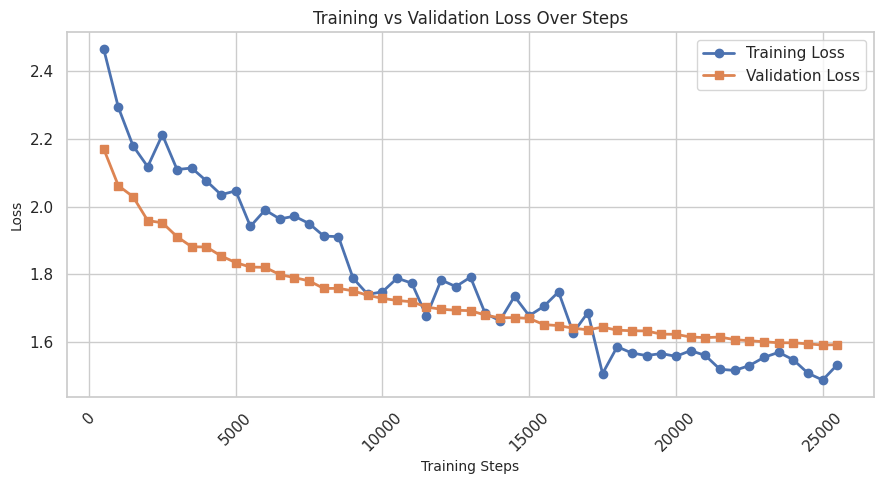

In [ ]:
import matplotlib.pyplot as plot
import seaborn as sns

sns.set(style="whitegrid")

steps = list(range(500, 25600, 500))
train_loss = [
    2.4665, 2.2934, 2.1796, 2.1178, 2.2123, 2.1094, 2.1139, 2.0758, 2.035,
    2.0462, 1.9412, 1.9897, 1.9632, 1.9713, 1.9496, 1.9125, 1.9107, 1.7876,
    1.7398, 1.7475, 1.7879, 1.7731, 1.6753, 1.7825, 1.763, 1.7908, 1.6836,
    1.662, 1.7338, 1.6767, 1.7046, 1.7473, 1.6263, 1.6861, 1.5055, 1.585,
    1.5662, 1.5588, 1.5648, 1.5565, 1.5733, 1.5593, 1.5182, 1.5148, 1.529,
    1.5534, 1.5684, 1.5463, 1.5066, 1.4863, 1.5318
]
val_loss = [
    2.1707, 2.0616, 2.0291, 1.9583, 1.9518, 1.9106, 1.8808, 1.8802, 1.8537,
    1.8340, 1.8207, 1.8200, 1.7984, 1.7895, 1.7798, 1.7574, 1.7578, 1.7502,
    1.7371, 1.7281, 1.7218, 1.7181, 1.7023, 1.6960, 1.6929, 1.6917, 1.6787,
    1.6703, 1.6712, 1.6687, 1.6505, 1.6474, 1.6398, 1.6349, 1.6430, 1.6339,
    1.6323, 1.6316, 1.6222, 1.6217, 1.6137, 1.6119, 1.6136, 1.6059, 1.6028,
    1.5997, 1.5966, 1.5966, 1.5934, 1.5899, 1.5911
]

plot.figure(figsize=(9, 5))
plot.plot(steps, train_loss, label='Training Loss', linewidth=2, marker='o')
plot.plot(steps, val_loss, label='Validation Loss', linewidth=2, marker='s')

plot.title("Training vs Validation Loss Over Steps", fontsize=12)
plot.xlabel("Training Steps", fontsize=10)
plot.ylabel("Loss", fontsize=10)
plot.legend()
plot.xticks(rotation=45)
plot.grid(True)
plot.tight_layout()
plot.show()

***Testing our model.***

In [ ]:
import torch
from transformers import BartForConditionalGeneration, BartTokenizer

modelName = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(modelName)
bartModel = BartForConditionalGeneration.from_pretrained(modelName)

inputText = (
    "Deep learning is a powerful branch of machine learning that is transforming technology and industry. "
    "By using multi-layered neural networks, it can automatically learn from complex data, making it essential "
    "for tasks such as image recognition, natural language processing, and speech recognition. "
    "Its importance lies in its ability to discover hidden patterns, driving innovation and progress."
)

inputIds = tokenizer.encode(inputText, return_tensors="pt", max_length=1024, truncation=True)

summaryIds = bartModel.generate(
    inputIds,
    num_beams=4,
    no_repeat_ngram_size=3,
    max_length=60,
    min_length=20,
    early_stopping=True
)

summaryText = tokenizer.decode(summaryIds[0], skip_special_tokens=True)

print("Original Text is:\n", inputText)
print("\nGenerated Summary is given as:\n", summaryText)

Original Text is:
 Deep learning is a powerful branch of machine learning that is transforming technology and industry. By using multi-layered neural networks, it can automatically learn from complex data, making it essential for tasks such as image recognition, natural language processing, and speech recognition. Its importance lies in its ability to discover hidden patterns, driving innovation and progress.

Generated Summary is given as:
 Deep learning is a powerful branch of machine learning that is transforming technology and industry. It can automatically learn from complex data, making it essential for tasks such as image recognition, natural language processing and speech recognition.


In [ ]:
saveDirectory = "./a2_part4_snallape_summarization_LLMs"
bartModel.save_pretrained(saveDirectory)
tokenizer.save_pretrained(saveDirectory)
print(f"\nModel & tokenizer weights saved to {saveDirectory}")

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



Model & tokenizer weights saved to ./a2_part4_snallape_summarization_LLMs


In [ ]:
import os
from google.colab import files

files.download("a2_part4_snallape_summarization_LLMs")

folderPath = "//content/a2_part4_snallape_summarization_LLMs"
zipFilename = "a2_part4_summarization_LLM.zip"

os.system(f"zip -r {zipFilename} {folderPath}")
files.download(zipFilename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3. Discuss any challenges faced during evaluation (e.g., handling long documents, variability in summary quality, etc.).

1. Truncation of Long Documents: BillSum entries are over 1024 tokens in length, aggressive truncation risked removing critical context from source documents.
2. Label Alignment Problems: Substituting -100 padding tokens in labels has be handled carefully when computing loss for both decoding & evaluation.
3. Memory Overflows During Evaluation: Evaluation on the whole test set using large batch sizes always caused CUDA out-of-memory errors, especially during the generation of summaries, that was hectic.
4. Uneven Summary Lengths: BillSum reference summaries vary a lot in length, & fixed-length generation gets difficult. Sometimes ill-matched when measured by ROUGE/BLEU.
5. Noisy ROUGE/BLEU Scores: ROUGE & BLEU scores usually failed to reflect semantic quality well, especially when the model generated paraphrased but accurate summaries.
6. Decoding Efficiency: Beam search generation where num_beams are set to 4 has reduced evaluation speed; but, greedy decoding led to quality loss.
7. BERTScore Latency: Dense semantically as it was, BERTScore had previously been computationally expensive and it took ~15-20 minutes to score on moderate hardware.
8. Tokenization Mismatch: Tokenized output & human-readable summary lack of correspondence did damage to BLEU scores due to hard n-gram matching.
9. Parallel Preprocessing Errors: num_proc > 1 inside.map() has resulted in occasional crashes when tokenizers or models weren't globally defined.
10. Metric Unification: Combining multiple evaluation metrics (ROUGE, BLEU, BERTScore) into a single evaluation pipeline required accurate input/output formatting for each data entry.

4. Propose potential modifications or extensions to enhance summarization quality.

To increase the summarization quality, we can try employing larger models like BART-large or T5, which are better at comprehending language. Training the model on bills or law documents can help it learn the corresponding language used there. Since some bills are long, we can also try employing models like Longformer, which are able to read more text at once. Another idea is to train the model on the basis of feedback in terms of summary quality (for instance ROUGE/BLEU metrics). Combining summaries from several models can also make the summary more robust. Finally, we can test the summaries at generation time to remove any mistakes or improve readability before presenting them.

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

1. Datasets: Billsum – summarization of US Congressional and California state bills, https://huggingface.co/datasets/FiscalNote/billsum
2. https://www.youtube.com/c/HuggingFace/featured
3. https://github.com/mjpost/sacrebleu
4. https://github.com/Tiiiger/bert_score
5. https://huggingface.co/docs/evaluate/types_of_evaluations
6. https://huggingface.co/facebook/bart-base
7. https://huggingface.co/spaces/evaluate-metric/bleu
8. https://huggingface.co/spaces/evaluate-metric/bertscore
9. https://github.com/google-research/google-research/tree/master/rouge
10. https://www.youtube.com/watch?v=fNssP2f40lU